### Introduction

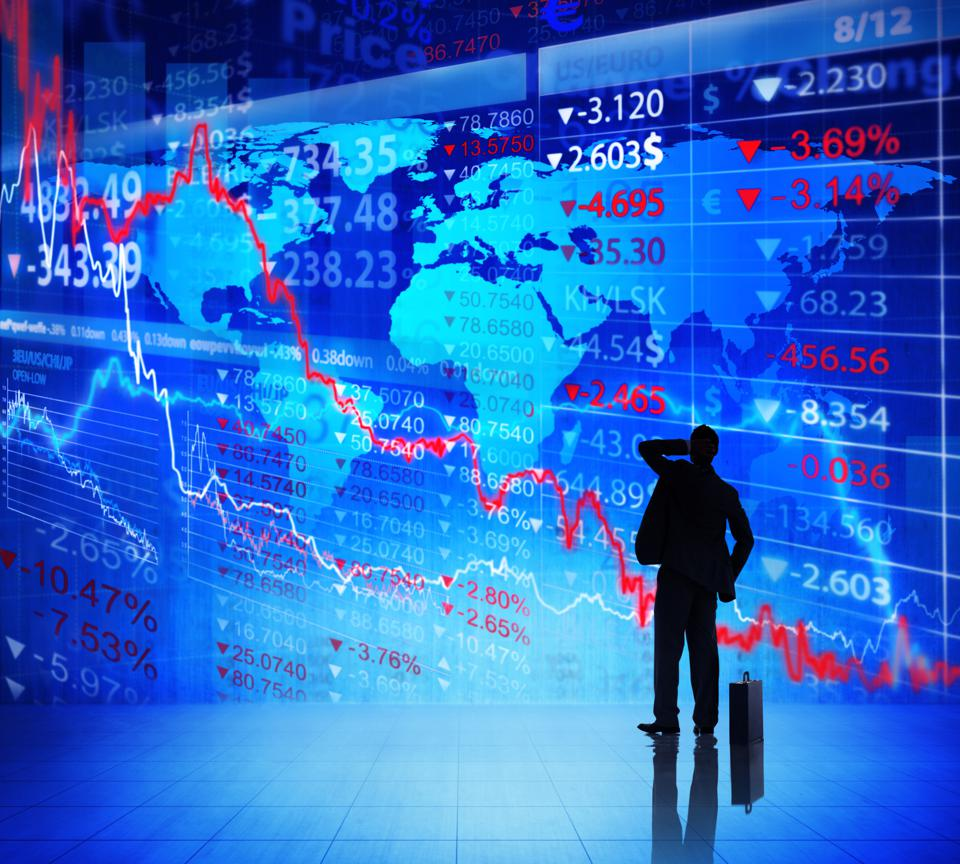

The goal of this kernel is to identify the trend in the future stock price of Yahoofinance based on previous years data.

We have historical stock data for `Yahoo Finance`. The stock dates back to as old as 1986, however for our model we will be looking at last 6 years of data, i.e. since 2014, and try to predict the stock price for January 2020. Then we will compare how close our predictions are to the true values. Is our model able to forcast the `ups` and `downs` accurately? 

So let's get started.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

import pylab
import os

Using TensorFlow backend.


In [2]:

os.chdir("D:/Study/Kernels/Notebooks/Time_Series")
plt.rcParams["figure.figsize"] = (7.5,5)
plt.style.use('seaborn')

pylab.rc('figure', figsize=(10,7))

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Load the Visualise the data

In [3]:
stock=pd.read_csv('YahooFinance_Stock_2014-2019.csv',header=0,index_col=0,parse_dates=True,squeeze=True)

In [4]:
stock.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-01-02,32.46,32.50,32.24,32.29,30632200
2014-01-03,32.33,32.35,31.81,32.08,31134800
2014-01-06,32.02,32.06,31.38,31.40,43603700
2014-01-07,31.57,31.71,31.47,31.64,35802800
2014-01-08,31.29,31.41,30.92,31.08,59971700


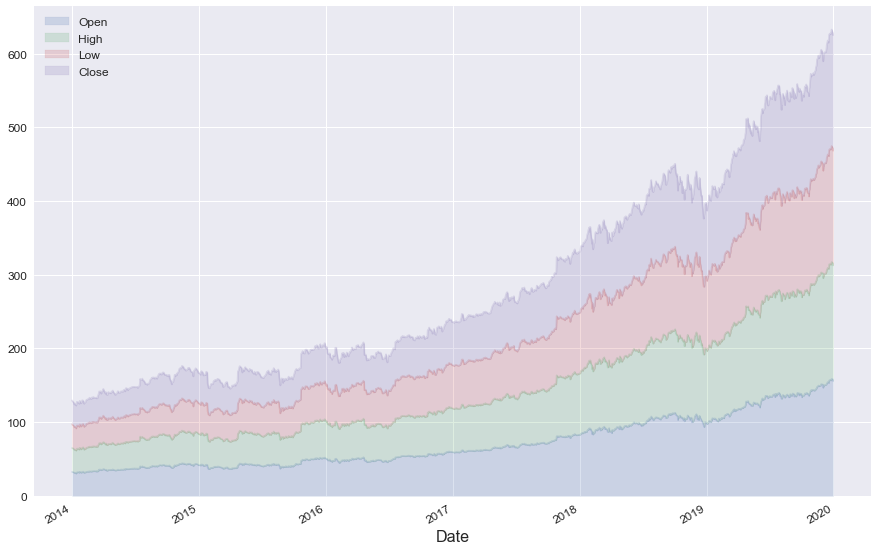

In [5]:
stock[["Open","High","Low","Close"]].plot.area(figsize=(15,10),alpha=0.2);

We are going to focus only on the Opening stocks and ignore the `Highs`, `Lows` and `Close` prices.

In [6]:
stock=stock["Open"]

In [7]:
groups=stock.groupby(pd.Grouper(freq='A'))

In [8]:
years={}
for name, group in groups:
    years[name.year] = group.values
    
years[2017]=np.append(years[2017],years[2017][-1]) ## Keeping the number of days same. Just to visualise the yearly data
years[2018]=np.append(years[2018],years[2018][-1]) 

In [9]:
years=pd.DataFrame(years)

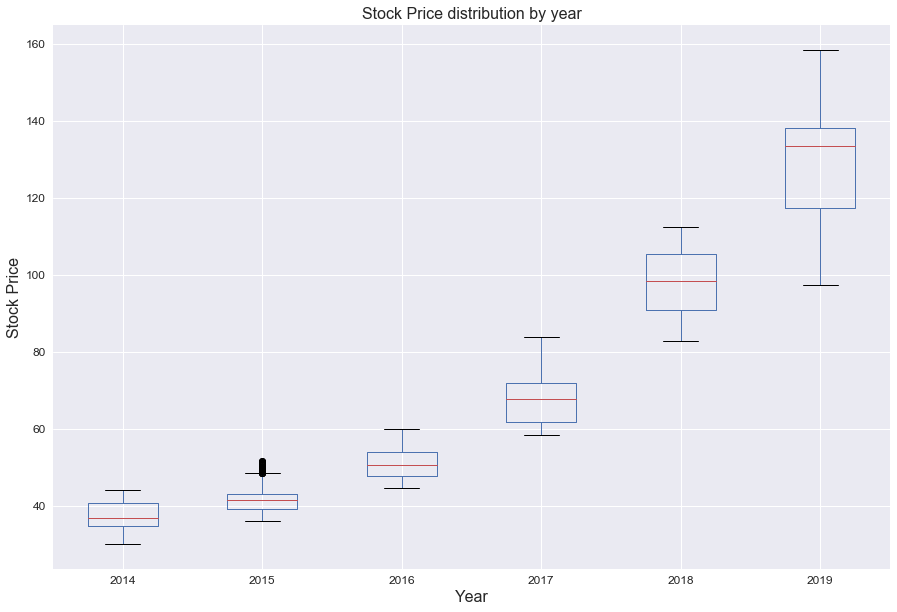

In [10]:
years.plot.box(figsize=(15,10))
plt.title('Stock Price distribution by year')
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.show()

Text(0.5, 1.0, 'A')

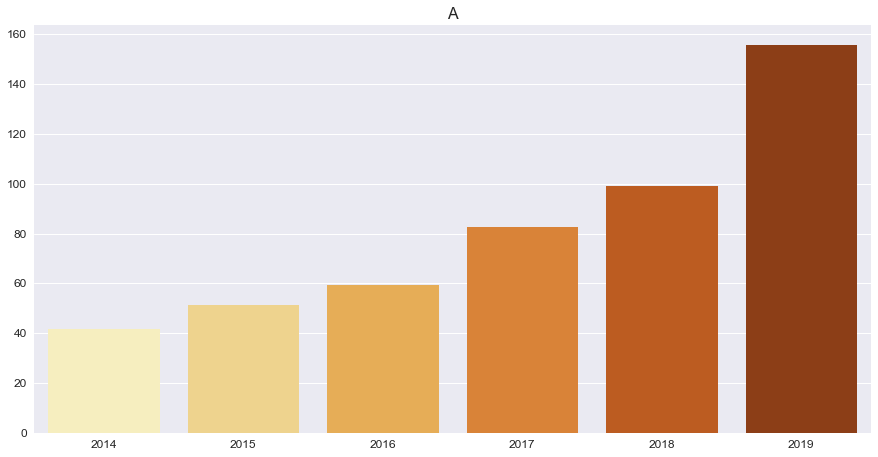

In [11]:
plt.figure(figsize=(15,7.5))
sns.barplot(years.iloc[-1,:].index,years.iloc[-1,:].values,palette='YlOrBr')
plt.title('A')

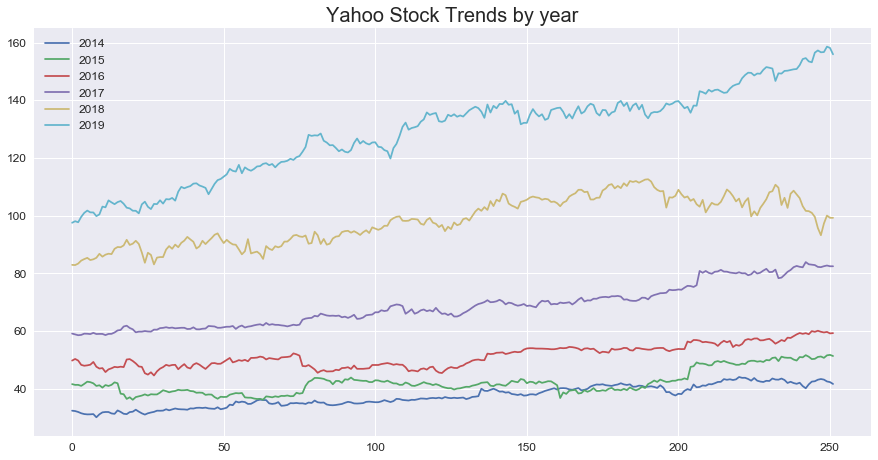

In [12]:
years.plot(figsize=(15,7.5))
plt.title('Yahoo Stock Trends by year',fontsize=20)
plt.show()

Except for '2015' where we see a little dip, there is a positive YoY trend with `2019 Q4` seeing some strong gains.

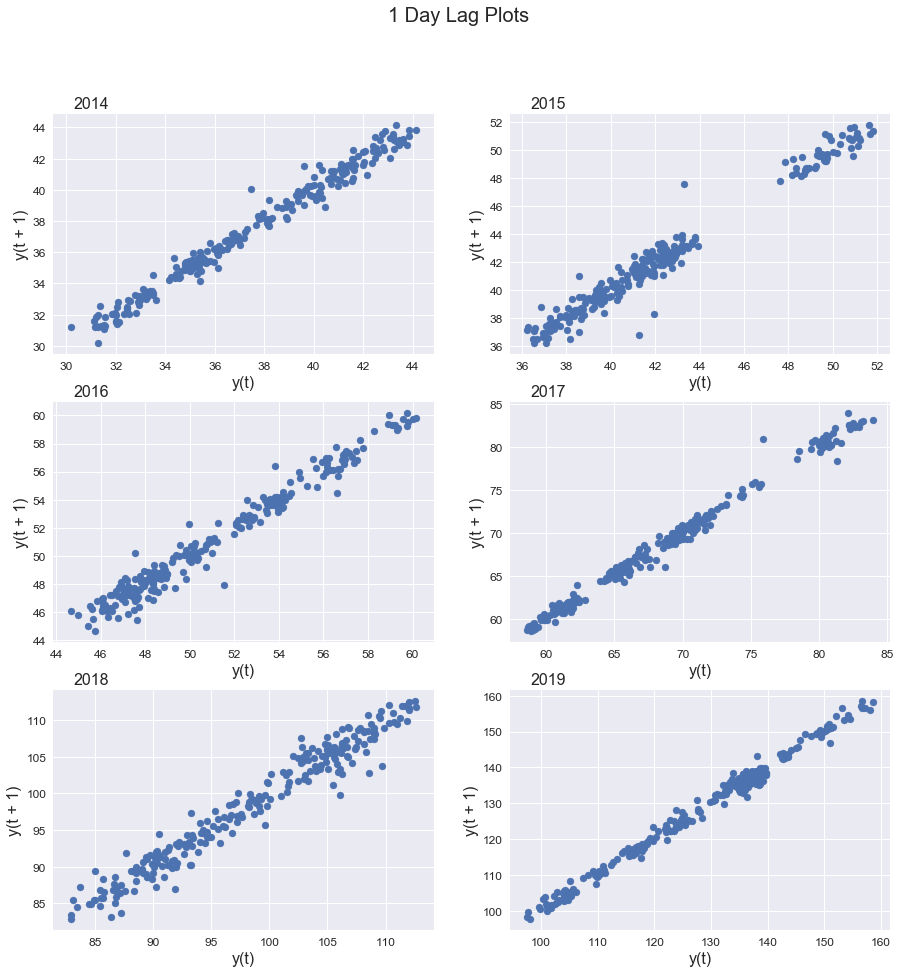

In [13]:
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(15,15))
pd.plotting.lag_plot(years[2014],ax=ax[0,0],lag=1)
pd.plotting.lag_plot(years[2015],ax=ax[0,1],lag=1)
pd.plotting.lag_plot(years[2016],ax=ax[1,0],lag=1)
pd.plotting.lag_plot(years[2017],ax=ax[1,1],lag=1)
pd.plotting.lag_plot(years[2018],ax=ax[2,0],lag=1)
pd.plotting.lag_plot(years[2019],ax=ax[2,1],lag=1)
fig.suptitle('1 Day Lag Plots',fontsize=20)
ax[0,0].set_title('2014',X=0.1)
ax[0,1].set_title('2015',X=0.1)
ax[1,0].set_title('2016',X=0.1)
ax[1,1].set_title('2017',X=0.1)
ax[2,0].set_title('2018',X=0.1)
ax[2,1].set_title('2019',X=0.1)
plt.show()

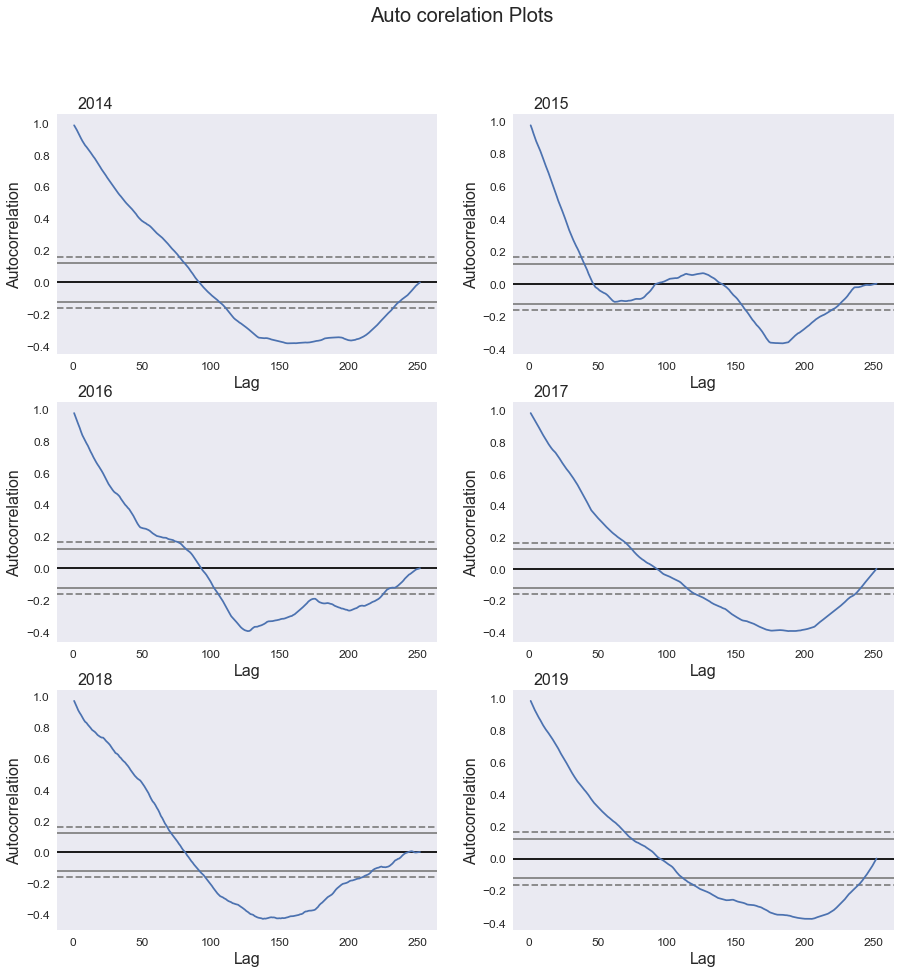

In [14]:
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(15,15))
pd.plotting.autocorrelation_plot(years[2014],ax=ax[0,0])
pd.plotting.autocorrelation_plot(years[2015],ax=ax[0,1])
pd.plotting.autocorrelation_plot(years[2016],ax=ax[1,0])
pd.plotting.autocorrelation_plot(years[2017],ax=ax[1,1])
pd.plotting.autocorrelation_plot(years[2018],ax=ax[2,0])
pd.plotting.autocorrelation_plot(years[2019],ax=ax[2,1])
fig.suptitle('Auto corelation Plots',fontsize=20)
ax[0,0].set_title('2014',X=0.1)
ax[0,1].set_title('2015',X=0.1)
ax[1,0].set_title('2016',X=0.1)
ax[1,1].set_title('2017',X=0.1)
ax[2,0].set_title('2018',X=0.1)
ax[2,1].set_title('2019',X=0.1)
#plt.rc('axes', titlesize=20)
plt.show()

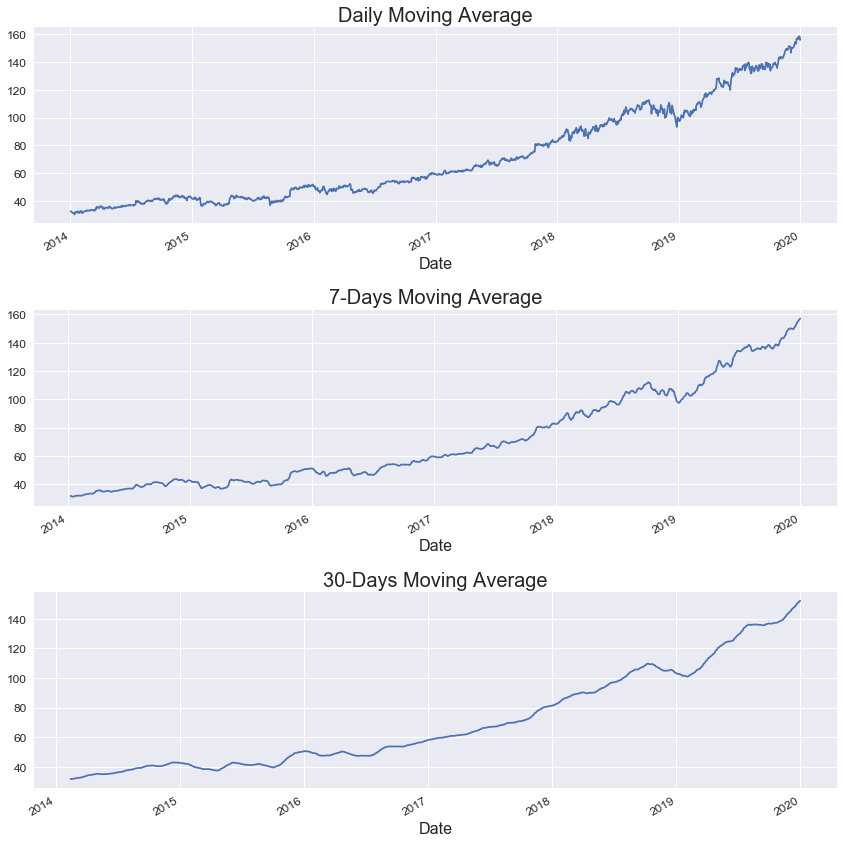

In [15]:
fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(12,12))
stock.rolling(window=1).mean().plot(ax=ax[0])
stock.rolling(window=7).mean().plot(ax=ax[1])
stock.rolling(window=30).mean().plot(ax=ax[2])
#stock.rolling(window=7).mean().plot(ax=ax[1,1])
#fig.suptitle('Auto corelation Plots',fontsize=20)
ax[0].set_title('Daily Moving Average',fontsize=20)
ax[1].set_title('7-Days Moving Average',fontsize=20)
ax[2].set_title('30-Days Moving Average',fontsize=20)
#ax[1,1].set_title('2016')
plt.tight_layout()

### Let's try to predict the future 1 year of  stock price based on a linear model and see how it looks, before building our actual model.

In [16]:
data_train=stock.reset_index()
data_train.columns=['ds','y']

In [17]:
model=Prophet()
model.fit(data_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
future=model.make_future_dataframe(periods=365)
predict=model.predict(future)

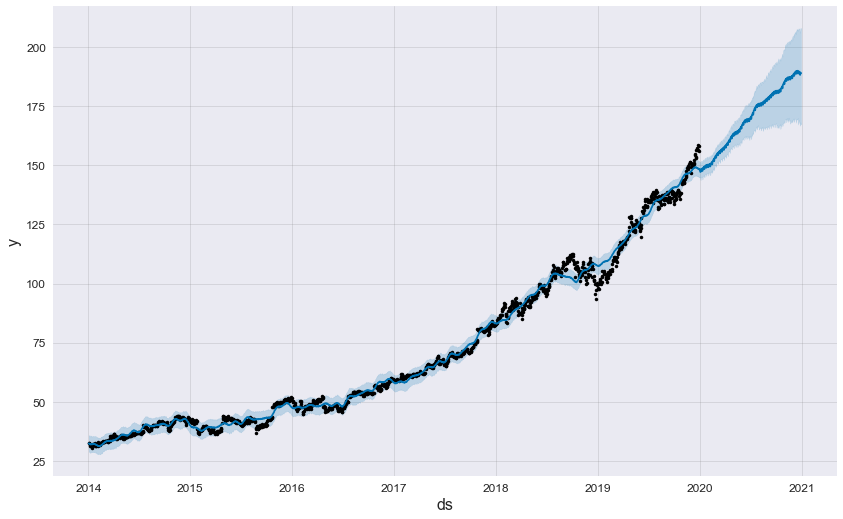

In [19]:
fig1=model.plot(predict,figsize=(12,7.5))

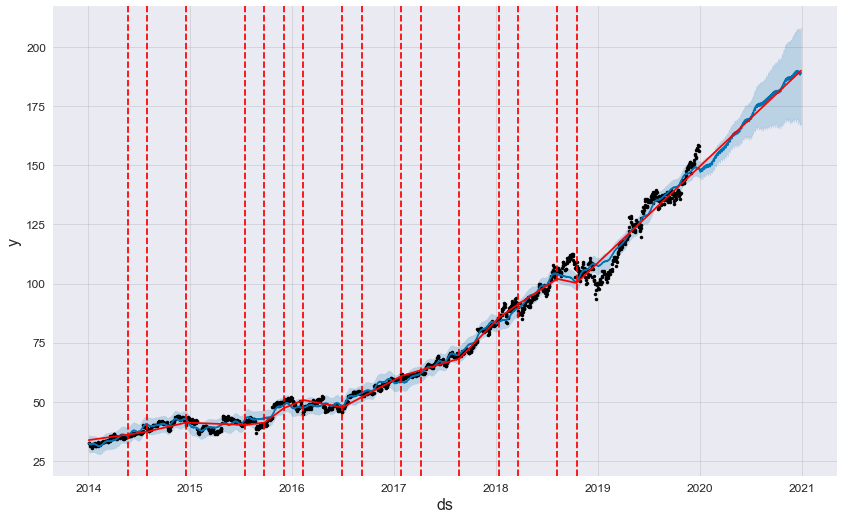

In [20]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(predict,figsize=(12,7.5))
a = add_changepoints_to_plot(fig.gca(), model, predict)

Although we see a similar trend, but this is clearly not a good fit to our training data.

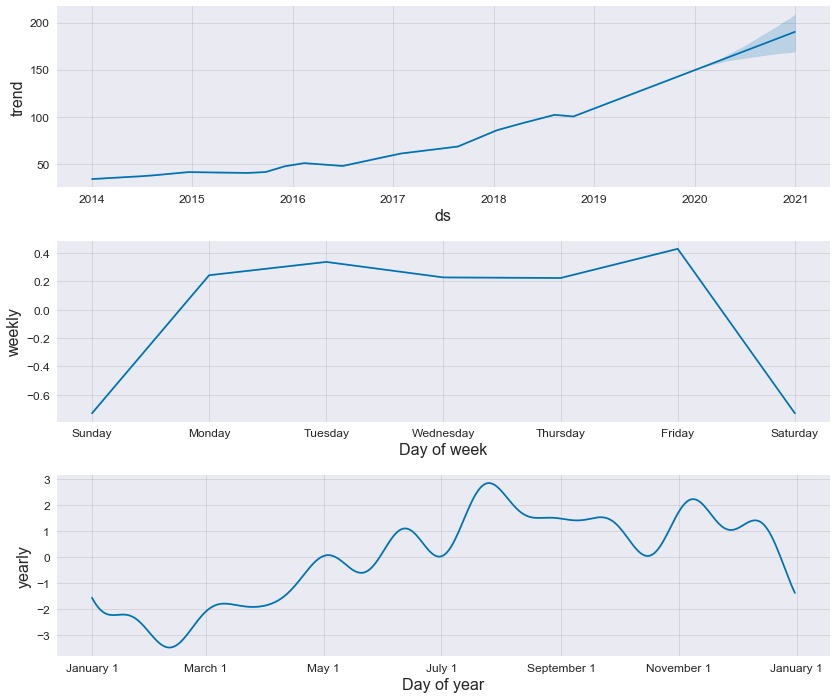

In [21]:
fig2=model.plot_components(predict,figsize=(12,10))

Now let's build our model to predict the stock price for Yahoo. The idea is to train the model to predict `d` day's stock based on past past 2 months stock prices `(d-60) `. We will create a 

In [22]:
training_dataset=pd.read_csv('YahooFinance_Stock_2014-2019.csv')
training_data=training_dataset.iloc[:,1:2].values

In [23]:
from sklearn.preprocessing import MinMaxScaler  #Normalising
sc=MinMaxScaler(feature_range=(0,1))
training_data=sc.fit_transform(training_data)

In [24]:
X_train=[]
y_train=[]
for i in range(60,len(training_data)):
    X_train.append(training_data[i-60:i,0])
    y_train.append(training_data[i,0])

X_train= np.array(X_train)
y_train=np.array(y_train)    

X_train=X_train.reshape((len(training_data)-60),60,1)


In [25]:
regressor= Sequential()

#Adding LSTM layers

regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

#Compiling RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')


In [26]:
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0277
Epoch 2/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 3/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0021
Epoch 4/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0026
Epoch 5/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 6/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0018
Epoch 7/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 8/50
1450/1450 [==============================] - 4s 2ms/step - loss: 0.0022
Epoch 9/50
1450/1450 [==============================] - 4s 2ms/step - loss: 0.0018
Epoch 10/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0020
Epoch 11/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 12/50
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0015
E

In [27]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [28]:
#new_model=tf.keras.models.load_model('google_stock_predict_model.h5')

In [32]:

#Getting the real stock price of 2020
test_dataset=pd.read_csv('YahooFinance_Stock_2020.csv')
real_stock_prices=test_dataset.iloc[:,1:2].values

In [33]:
total_dataset=pd.concat((training_dataset['Open'],test_dataset['Open']),axis=0)
inputs=total_dataset.iloc[len(total_dataset)-len(test_dataset)-60:].values
inputs=inputs.reshape(-1,1)

In [34]:
inputs=sc.transform(inputs)

X_test=[]
for i in range(60,(60+len(real_stock_prices))):
    X_test.append(inputs[i-60:i,0])

In [35]:
X_test= np.array(X_test)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

predicted_stock_values=regressor.predict(X_test)
predicted_stock_values=sc.inverse_transform(predicted_stock_values)

In [36]:
predict_2020=predict[(predict['ds']>'2019-12-31') & (predict['ds']<'2020-8-01')][['ds','trend']]  ##Extracting January prediction from linear Model
predict_2020=predict_2020.set_index('ds',drop=True)

In [37]:
Xt=test_dataset.set_index('Date',drop=True)  ##Ignoring the holidays
new=Xt.join(predict_2020)
linear_prediction=new['trend'].values.reshape(len(new),1)

In [38]:
Year_2020=pd.DataFrame(np.concatenate((real_stock_prices,predicted_stock_values,linear_prediction),axis=1),index=test_dataset['Date'],columns=['Real','Predicted','Linear'])
Year_2020.index = pd.to_datetime(Year_2020.index)
Year_2020.tail()

,Real,Predicted,Linear
Date,,,
2020-07-27,201.47,206.582153,172.672510
2020-07-28,203.61,206.625412,172.784161
2020-07-29,202.50,206.570572,172.895812
2020-07-30,201.00,206.429016,173.007463
2020-07-31,204.40,206.210510,173.119114


In [39]:
groups_real = Year_2020['Real'].groupby(pd.Grouper(freq='M'))
groups_predict = Year_2020['Predicted'].groupby(pd.Grouper(freq='M'))

months_real = pd.concat([pd.DataFrame(x[1].values) for x in groups_real], axis=1)
months_predict = pd.concat([pd.DataFrame(x[1].values) for x in groups_predict], axis=1)

months_real = pd.DataFrame(months_real)
months_predict = pd.DataFrame(months_predict)

months_real.columns = ['Jan','Feb','Mar','Apr','May','Jun','July']
months_predict.columns = ['Jan','Feb','Mar','Apr','May','Jun','July']

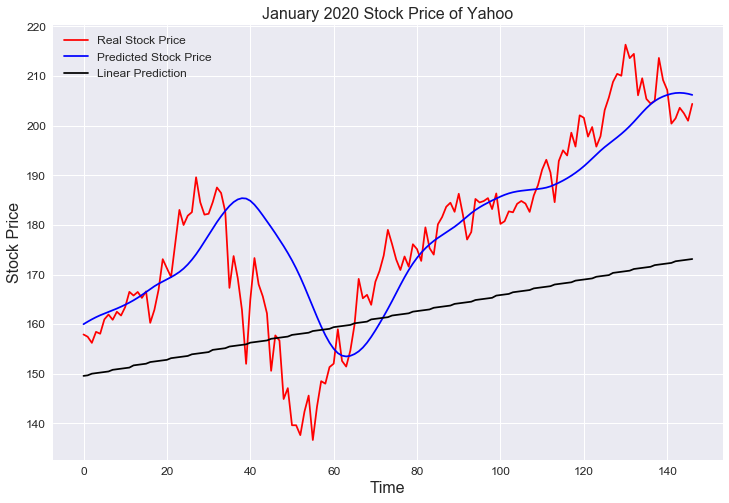

In [40]:
plt.figure(figsize=(12,8))
plt.plot(real_stock_prices,color='red',label='Real Stock Price')
plt.plot(predicted_stock_values,color='blue',label='Predicted Stock Price')
#plt.plot(predicted_stock_values_2,color='green',label='Predicted Google Stock Price_2')
plt.plot(linear_prediction,color='black',label='Linear Prediction')
plt.title('January 2020 Stock Price of Yahoo')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

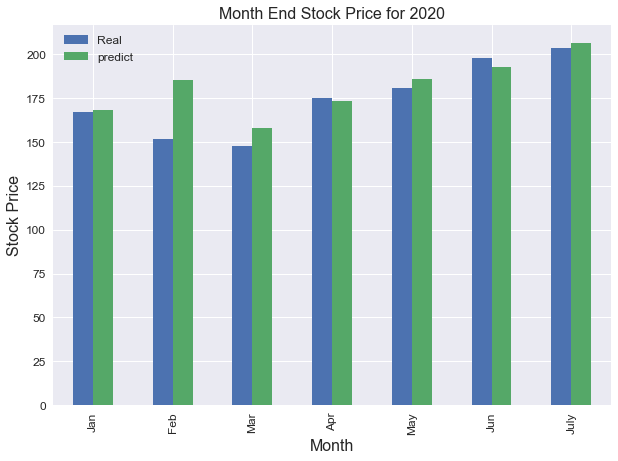

In [41]:
mon=pd.DataFrame({'Real':months_real[18:19].values.ravel(),'predict':months_predict[18:19].values.ravel()},index=months_real[18:19].columns)
mon.plot(kind='bar')
plt.xlabel("Month")
plt.ylabel("Stock Price")
plt.title("Month End Stock Price for 2020")
plt.show()

## Thank You